# Preparation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
print(tf.__version__)

SEED = 1234
NUM_FORECASTS = 7 #7 days

2.5.0


# Load Data and Build Functions

In [2]:
#Load data and assign datetime
dataset = pd.read_csv("data_all_region.csv")
dataset["tanggal"] = pd.to_datetime(dataset["tanggal"], format="%Y/%m/%d")

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, batch_size, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Preparation for Modelling

In [5]:
window_size = 30
batch_size = 8
shuffle_buffer_size = 1000

## Check Model Performance on One Region (Cakung)

In [6]:
ds_cakung = dataset[dataset["nama_kecamatan"] == "CAKUNG"]
series = ds_cakung["positif"].values
time = ds_cakung.index.values + 1

In [7]:
split_time = int(0.9 * len(series))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation="relu", input_shape = [None, 1]),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=0.00005)
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model.fit(train_set, epochs=50, verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(225,)


C:\Users\Vandi\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Check Performance on Test

In [9]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], batch_size, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [10]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

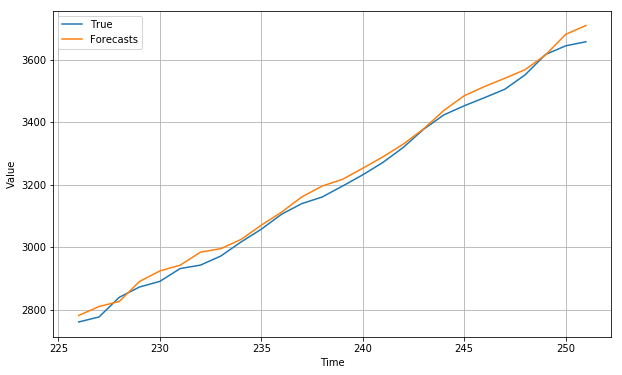

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="True")
plot_series(time_valid, rnn_forecast, label="Forecasts")
plt.legend()

### Check Performance on Both Training and Testing

In [12]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], batch_size, window_size)
rnn_forecast = rnn_forecast[:split_time - window_size, -1, 0]

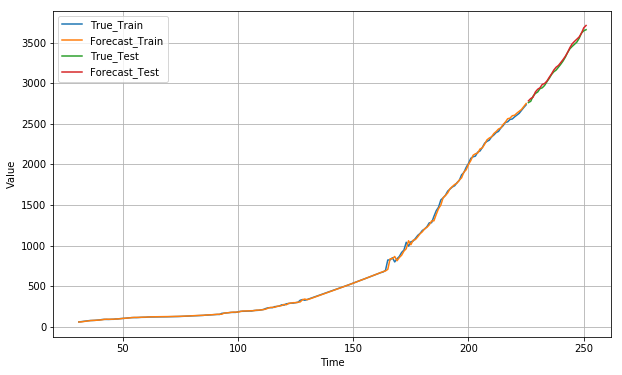

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_train[window_size:], x_train[window_size:], label="True_Train")
plot_series(time_train[window_size:], rnn_forecast[:], label="Forecast_Train")

rnn_forecast_2 = model_forecast(model, series[:, np.newaxis], batch_size, window_size)
rnn_forecast_2 = rnn_forecast_2[split_time - window_size:-1, -1, 0]

plot_series(time_valid, x_valid, label="True_Test")
plot_series(time_valid, rnn_forecast_2, label="Forecast_Test")

plt.legend()

In [14]:
#Mape Metrics
print("MAPE on tests:",tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast_2).numpy())
print("MAPE on train:",tf.keras.metrics.mean_absolute_percentage_error(x_train[window_size:], rnn_forecast).numpy())
print("MSE on tests:",tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast_2).numpy())
print("MSE on train:",tf.keras.metrics.mean_squared_error(x_train[window_size:], rnn_forecast).numpy())

MAPE on tests: 0.69400996
MAPE on train: 1.4293511
MSE on tests: 653.3853
MSE on train: 305.2319


# Proceed to All Region and Forecast

In [15]:
output_data = pd.DataFrame(columns = ["kecamatan", "tanggal", "prediksi"])
for i in tqdm(dataset["nama_kecamatan"].unique()):
    #Preparing Data
    ds_temp = dataset[dataset["nama_kecamatan"] == i]
    x_train = ds_temp["positif"].values
    time = ds_temp["tanggal"].values[-1]
    
    #Buld Model
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation="relu", input_shape = [None, 1]),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                  optimizer=optimizer,
                  metrics=["mse", "mae"])
    history = model.fit(train_set, epochs=50, verbose=0)
    
    #Forecasting
    data_temp = series.copy()
    for j in range(NUM_FORECASTS):
        rnn_forecast = model_forecast(model, data_temp[-window_size:, np.newaxis], 8, window_size)
        rnn_forecast = rnn_forecast[:, -1, 0]
        data_temp = np.append(data_temp, round(rnn_forecast[0]))
        time += np.timedelta64(1,'D')
        output_data = output_data.append({"kecamatan":i, "tanggal":time,
                                        "prediksi":round(rnn_forecast[0])}, 
                                        ignore_index=True)    

100%|██████████████████████████████████████████| 10/10 [01:09<00:00,  6.92s/it]


In [16]:
output_data.sample(5)

,kecamatan,tanggal,prediksi
46,MAKASAR,2020-12-05,3948
57,PASAR REBO,2020-12-02,3775
33,JATINEGARA,2020-12-06,3979
36,KRAMAT JATI,2020-12-02,3775
6,CAKUNG,2020-12-07,4099


### Save the Output File

In [17]:
output_data.to_csv("final_output.csv", index=False)